In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('CrimesOnWomenData.csv')
df

,Unnamed: 0,State,Year,Rape,K&A,DD,AoW,AoM,DV,WT
0,0,ANDHRA PRADESH,2001,871,765,420,3544,2271,5791,7
1,1,ARUNACHAL PRADESH,2001,33,55,0,78,3,11,0
2,2,ASSAM,2001,817,1070,59,850,4,1248,0
3,3,BIHAR,2001,888,518,859,562,21,1558,83
4,4,CHHATTISGARH,2001,959,171,70,1763,161,840,0
...,...,...,...,...,...,...,...,...,...,...
731,731,D&N Haveli,2021,1250,4083,141,2068,417,4731,4
732,732,Daman & Diu,2021,315,904,16,1851,10,501,1
733,733,Delhi UT,2021,2,1,0,5,1,9,0
734,734,Lakshadweep,2021,0,0,0,1,1,3,0


In [62]:
df['State'].values

array(['ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR',
       'CHHATTISGARH', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH',
       'JAMMU & KASHMIR', 'JHARKHAND', 'KARNATAKA', 'KERALA',
       'MADHYA PRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM',
       'NAGALAND', 'ODISHA', 'PUNJAB', 'RAJASTHAN', 'SIKKIM',
       'TAMIL NADU', 'TRIPURA', 'UTTAR PRADESH', 'UTTARAKHAND',
       'WEST BENGAL', 'A & N ISLANDS', 'CHANDIGARH', 'D & N HAVELI',
       'DAMAN & DIU', 'LAKSHADWEEP', 'PUDUCHERRY', 'ANDHRA PRADESH',
       'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHHATTISGARH', 'GOA',
       'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR',
       'JHARKHAND', 'KARNATAKA', 'KERALA', 'MADHYA PRADESH',
       'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND',
       'ODISHA', 'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'TRIPURA',
       'UTTAR PRADESH', 'UTTARAKHAND', 'WEST BENGAL', 'A & N ISLANDS',
       'CHANDIGARH', 'D & N HAVELI', 'DAMAN & DIU'

In [28]:
 # Create lag features (previous year's crime rates)
crime_types = ['Rape', 'K&A', 'DD', 'AoW','AoM','DV','WT']

In [39]:
# Prepare the data
def prepare_data(df, target_crime):
    # Create a feature for the year
    df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year
    
    # Create lag features (previous year's crime rates)
    for crime in crime_types:
        df[f'{crime}_prev_year'] = df.groupby('State')[crime].shift(1)
    
    # Drop the first year of data (which will have NaN for lag features)
    df = df.dropna()
    
    # Prepare features and target
    X = df[['Year'] + [f'{crime}_prev_year' for crime in crime_types]]
    y = df[target_crime]
    
    return X, y

In [40]:
# Choose a crime type to predict
target_crime = 'Rape'

In [41]:
# Prepare the data
X, y = prepare_data(df, target_crime)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [45]:
# Making Predictions
y_pred = model.predict(X_test_scaled)

In [46]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 117865.43904179103
R2 Score: 0.8552132843664055


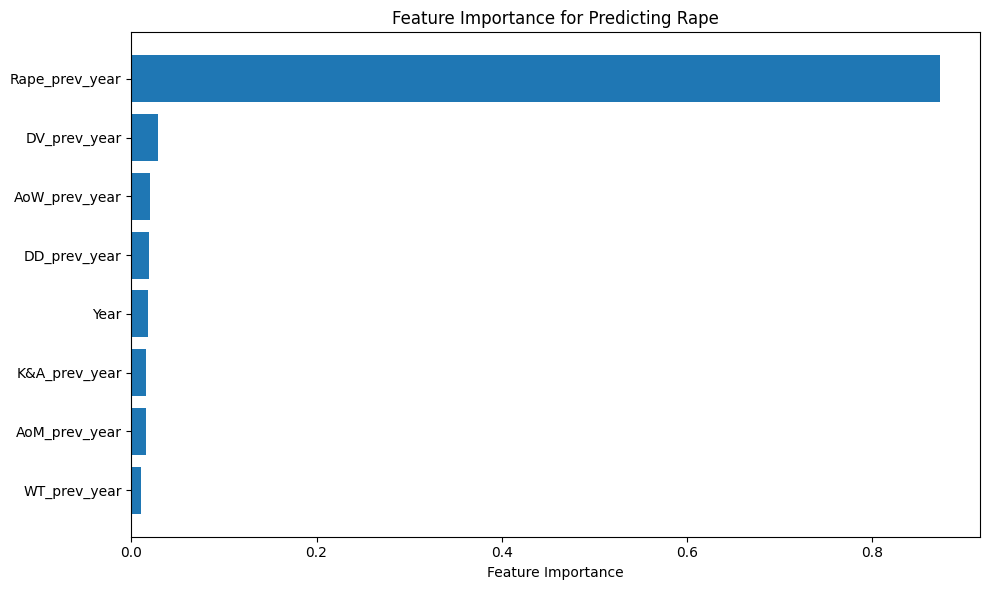

In [47]:
# Plot feature importances
feature_importance = model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title(f'Feature Importance for Predicting {target_crime}')
plt.tight_layout()
plt.show()

In [48]:
# Function to predict future crime rates
def predict_future(model, scaler, last_year_data, num_years=5):
    future_predictions = []
    current_data = last_year_data.copy()
    
    for _ in range(num_years):
        current_data['Year'] += 1
        scaled_data = scaler.transform(current_data.values.reshape(1, -1))
        prediction = model.predict(scaled_data)[0]
        future_predictions.append(prediction)
        
        # Update the lag features for the next prediction
        for crime in crime_types:
            current_data[f'{crime}_prev_year'] = prediction
    
    return future_predictions

In [49]:
# Get the last year's data
last_year_data = X.iloc[-1:].copy()

In [50]:
# Predict for the next 5 years
future_predictions = predict_future(model, scaler, last_year_data, num_years=5)

print(f"\nPredictions for {target_crime} for the next 5 years:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Year {last_year_data['Year'].values[0] + i}: {pred:.2f}")


Predictions for Rape for the next 5 years:
Year 2022: 27.00
Year 2023: 122.42
Year 2024: 140.24
Year 2025: 143.16
Year 2026: 142.62


D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### With State and Crime

In [54]:
# Prepare the data
def prepare_data(df, target_crime, target_state):
    # Filter data for the target state
    df_state = df[df['State'] == target_state]
    
    # Create a feature for the year
    df_state['Year'] = pd.to_datetime(df_state['Year'], format='%Y').dt.year
    
    # Create lag features (previous year's crime rates)
    for crime in crime_types:
        df_state[f'{crime}_prev_year'] = df_state[crime].shift(1)
    
    # Drop the first year of data (which will have NaN for lag features)
    df_state = df_state.dropna()
    
    # Prepare features and target
    X = df_state[['Year'] + [f'{crime}_prev_year' for crime in crime_types]]
    y = df_state[target_crime]
    
    return X, y

In [51]:
# Function to train model and make predictions
def train_and_predict(X, y, num_years=5):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions on test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")

    # Plot feature importances
    feature_importance = model.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Feature Importance for Predicting {target_crime} in {target_state}')
    plt.tight_layout()
    plt.show()

    # Predict future
    last_year_data = X.iloc[-1:].copy()
    future_predictions = []
    current_data = last_year_data.copy()
    
    for _ in range(num_years):
        current_data['Year'] += 1
        scaled_data = scaler.transform(current_data.values.reshape(1, -1))
        prediction = model.predict(scaled_data)[0]
        future_predictions.append(prediction)
        
        # Update the lag features for the next prediction
        for crime in crime_types:
            current_data[f'{crime}_prev_year'] = prediction
    
    return future_predictions, last_year_data['Year'].values[0]

In [63]:
# Set the target state and crime type
target_state = "PUDUCHERRY"  
target_crime = "Rape"

In [64]:
# Prepare the data for the specific state and crime type
X, y = prepare_data(df, target_crime, target_state)

C:\Users\Sham\AppData\Local\Temp\ipykernel_28964\557187091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['Year'] = pd.to_datetime(df_state['Year'], format='%Y').dt.year
C:\Users\Sham\AppData\Local\Temp\ipykernel_28964\557187091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state[f'{crime}_prev_year'] = df_state[crime].shift(1)


Mean Squared Error: 37.557249999999996
R2 Score: -149.22899999999998


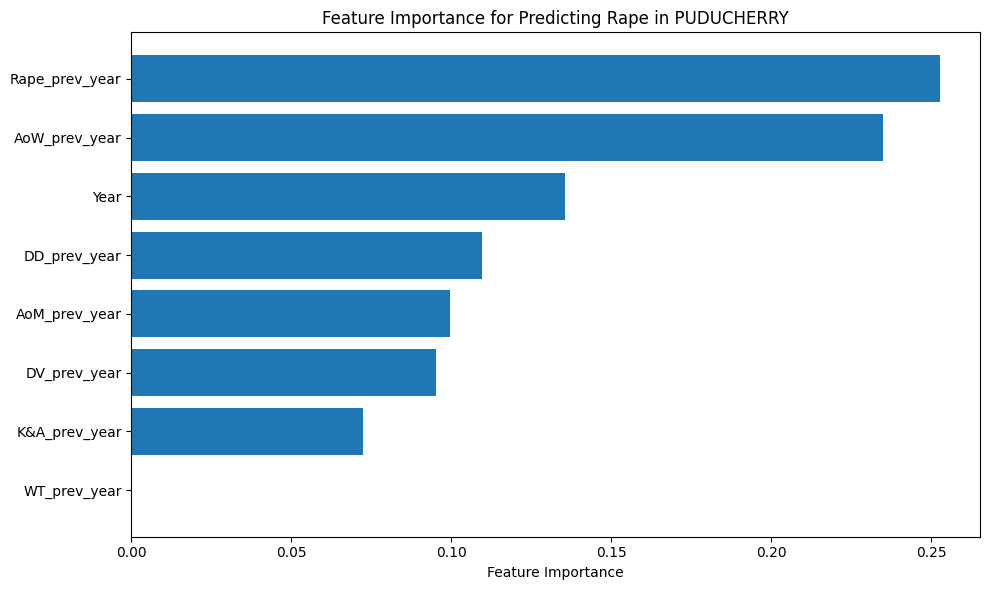

D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [65]:
# Train the model and get predictions
future_predictions, last_year = train_and_predict(X, y, num_years=5)

In [66]:
# Print the predictions
print(f"\nPredictions for {target_crime} in {target_state} for the next 5 years:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Year {last_year + i}: {pred:.2f}")


Predictions for Rape in PUDUCHERRY for the next 5 years:
Year 2011: 4.56
Year 2012: 6.45
Year 2013: 6.79
Year 2014: 6.84
Year 2015: 6.84


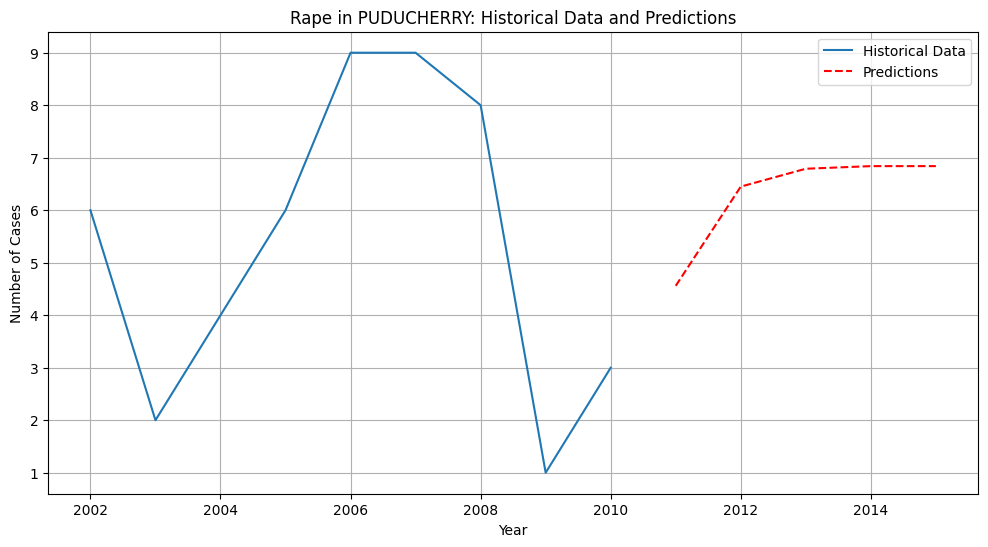

In [67]:

# Plot the historical data and predictions
plt.figure(figsize=(12, 6))
plt.plot(X['Year'], y, label='Historical Data')
future_years = range(last_year + 1, last_year + 6)
plt.plot(future_years, future_predictions, 'r--', label='Predictions')
plt.title(f'{target_crime} in {target_state}: Historical Data and Predictions')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()